<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Lam_and_Epsilon_when_cost_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nashpy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nashpy as nash
from matplotlib.colors import ListedColormap
from tqdm import tqdm

In [5]:
# Fixed parameters
alpha = 0.5  # Probability of a good paper
r = 1.0      # Reward for author when accepted

# Define the costs we want to analyze
costs = [0.01, 0.1, 0.5]

# Author and journal strategies
# 0: Always Submit/Accept, 1: Only Good, 2: Only Bad, 3: Never Submit/Reject All
strategies = [0, 1, 2, 3]
author_strategy_names = ['Always Submit', 'Only Submit Good', 'Only Submit Bad', 'Never Submit']
journal_strategy_names = ['Always Accept', 'Only Accept Good', 'Only Accept Bad', 'Reject All']


In [6]:
# Define acceptance probability function
def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

In [7]:
# Calculate author and journal payoffs
def author_journal_payoff(author_strategy, journal_strategy, alpha, epsilon, lam, r, c):
    if author_strategy == 0:  # Always Submit
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:  # Only Submit Good
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:  # Only Submit Bad
        good_prob, bad_prob = 0, 1 - alpha
    else:  # No Submit
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate
    # Avoid division by zero
    if accept_rate > 0:
        author_payoff = accept_rate * r - reject_rate * c
        journal_payoff = (good_prob * p_accept_good) / accept_rate
    else:
        author_payoff = -reject_rate * c
        journal_payoff = 0

    return author_payoff, journal_payoff

In [8]:
# Function to find the best author strategy against a given journal strategy
def find_best_author_strategy(journal_strategy, epsilon, lam, r, c, alpha):
    payoffs = [author_journal_payoff(a_strat, journal_strategy, alpha, epsilon, lam, r, c)[0]
               for a_strat in strategies]
    return np.argmax(payoffs)


In [9]:

# Analyze Nash equilibria for a grid of epsilon and lambda values
def analyze_equilibria(cost_value, resolution=40):
    epsilon_values = np.linspace(0, 1, resolution)
    lambda_values = np.linspace(0, 1, resolution)

    # Create result grids for dominant strategies
    journal_strategy_grid = np.zeros((resolution, resolution), dtype=int)
    author_strategy_grid = np.zeros((resolution, resolution), dtype=int)

    for i, epsilon in enumerate(tqdm(epsilon_values)):
        for j, lam in enumerate(lambda_values):
            # For each combination of epsilon and lambda, evaluate all strategy pairs
            strategy_payoffs = {}

            for j_strat in strategies:  # Journal strategies
                # Find the best response of authors to this journal strategy
                a_strat = find_best_author_strategy(j_strat, epsilon, lam, r, cost_value, alpha)

                # Calculate resulting payoffs
                author_payoff, journal_payoff = author_journal_payoff(
                    a_strat, j_strat, alpha, epsilon, lam, r, cost_value)

                strategy_payoffs[(a_strat, j_strat)] = (author_payoff, journal_payoff)

            # Check if any strategy pair is a Nash equilibrium
            nash_equilibria = []

            for (a_strat, j_strat), (a_payoff, j_payoff) in strategy_payoffs.items():
                # Check if author has no better response
                author_best_response = True
                for alt_a_strat in strategies:
                    if alt_a_strat != a_strat:
                        alt_payoff = author_journal_payoff(
                            alt_a_strat, j_strat, alpha, epsilon, lam, r, cost_value)[0]
                        if alt_payoff > a_payoff:
                            author_best_response = False
                            break

                # Check if journal has no better response
                journal_best_response = True
                for alt_j_strat in strategies:
                    if alt_j_strat != j_strat:
                        # Best author response to this alternative journal strategy
                        best_a_response = find_best_author_strategy(
                            alt_j_strat, epsilon, lam, r, cost_value, alpha)
                        alt_payoff = author_journal_payoff(
                            best_a_response, alt_j_strat, alpha, epsilon, lam, r, cost_value)[1]
                        if alt_payoff > j_payoff:
                            journal_best_response = False
                            break

                if author_best_response and journal_best_response:
                    nash_equilibria.append((a_strat, j_strat, a_payoff, j_payoff))

            # Choose the equilibrium with highest social welfare (sum of payoffs)
            if nash_equilibria:
                best_eq = max(nash_equilibria, key=lambda eq: eq[2] + eq[3])
                author_strategy_grid[i, j] = best_eq[0]
                journal_strategy_grid[i, j] = best_eq[1]

    return epsilon_values, lambda_values, author_strategy_grid, journal_strategy_grid

Analyzing cost = 0.01...


100%|██████████| 40/40 [00:00<00:00, 137.82it/s]


Analyzing cost = 0.1...


100%|██████████| 40/40 [00:00<00:00, 150.06it/s]


Analyzing cost = 0.5...


100%|██████████| 40/40 [00:00<00:00, 180.23it/s]


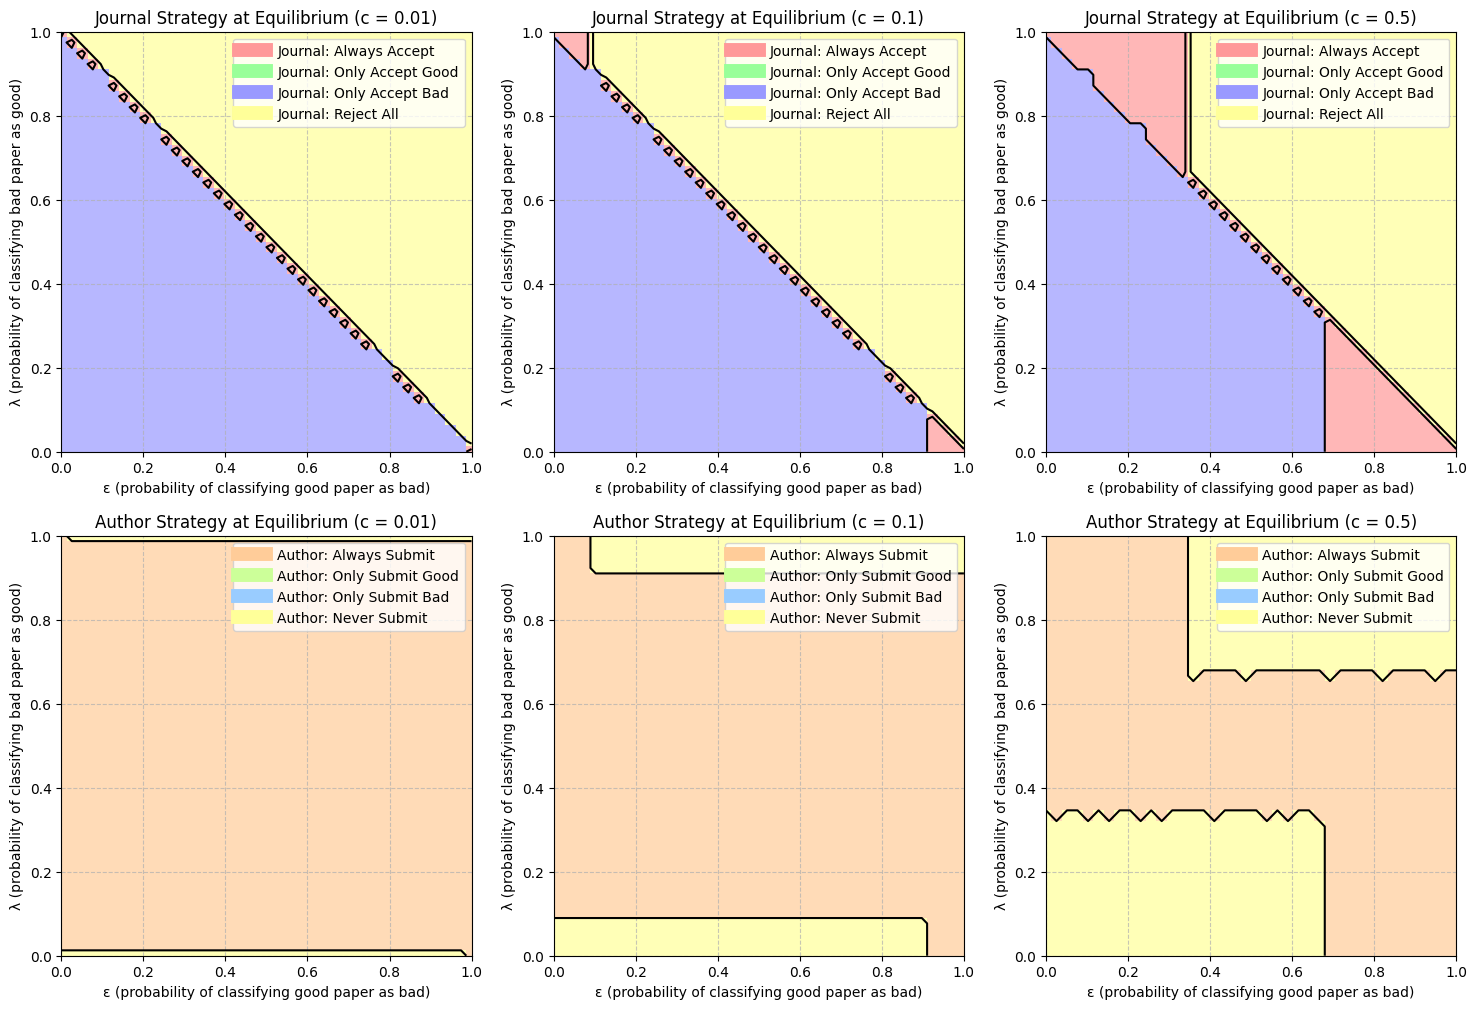

In [11]:
# Create plots for each cost value
plt.figure(figsize=(18, 12))
for idx, cost in enumerate(costs):
    # Plot journal strategies
    plt.subplot(2, 3, idx+1)

    print(f"Analyzing cost = {cost}...")
    epsilon_values, lambda_values, author_grid, journal_grid = analyze_equilibria(cost)

    # Create meshgrid for plotting
    epsilon_mesh, lambda_mesh = np.meshgrid(epsilon_values, lambda_values)

    # Define region colors for journal
    journal_color_map = ListedColormap(['#ff9999', '#99ff99', '#9999ff', '#ffff99'])

    # Plot the regions based on journal strategies
    plt.pcolormesh(epsilon_values, lambda_values, journal_grid.T, cmap=journal_color_map, alpha=0.7)

    # Add decision boundaries
    contour = plt.contour(epsilon_mesh, lambda_mesh, journal_grid.T, colors='black', linestyles='solid', levels=np.arange(0.5, 4))

    plt.title(f'Journal Strategy at Equilibrium (c = {cost})')
    plt.xlabel('ε (probability of classifying good paper as bad)')
    plt.ylabel('λ (probability of classifying bad paper as good)')

    # Create a custom legend for journal
    journal_lines = [plt.Line2D([0], [0], color=journal_color_map(i/3), lw=10) for i in range(4)]
    journal_labels = [f'Journal: {strat}' for strat in journal_strategy_names]
    plt.legend(journal_lines, journal_labels, loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Plot author strategies
    plt.subplot(2, 3, idx+4)

    # Define region colors for author
    author_color_map = ListedColormap(['#ffcc99', '#ccff99', '#99ccff', '#ffff99'])

    # Plot the regions based on author strategies
    plt.pcolormesh(epsilon_values, lambda_values, author_grid.T, cmap=author_color_map, alpha=0.7)

    # Add decision boundaries
    contour = plt.contour(epsilon_mesh, lambda_mesh, author_grid.T, colors='black', linestyles='solid', levels=np.arange(0.5, 4))

    plt.title(f'Author Strategy at Equilibrium (c = {cost})')
    plt.xlabel('ε (probability of classifying good paper as bad)')
    plt.ylabel('λ (probability of classifying bad paper as good)')

    # Create a custom legend for author
    author_lines = [plt.Line2D([0], [0], color=author_color_map(i/3), lw=10) for i in range(4)]
    author_labels = [f'Author: {strat}' for strat in author_strategy_names]
    plt.legend(author_lines, author_labels, loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(0, 1)